In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
#import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
TARGET_COLOR = '#109747'
NONTARGET_COLOR = 'black'

act_directory = 'D:\\Analysis_Cache_M2_300'#'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
beh_directory = 'Z:\\Behavioor'


animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
#animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
BS_animal_M2 = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']

stdfont = 14
stdyfrac = 0.06

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\Dual\../../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

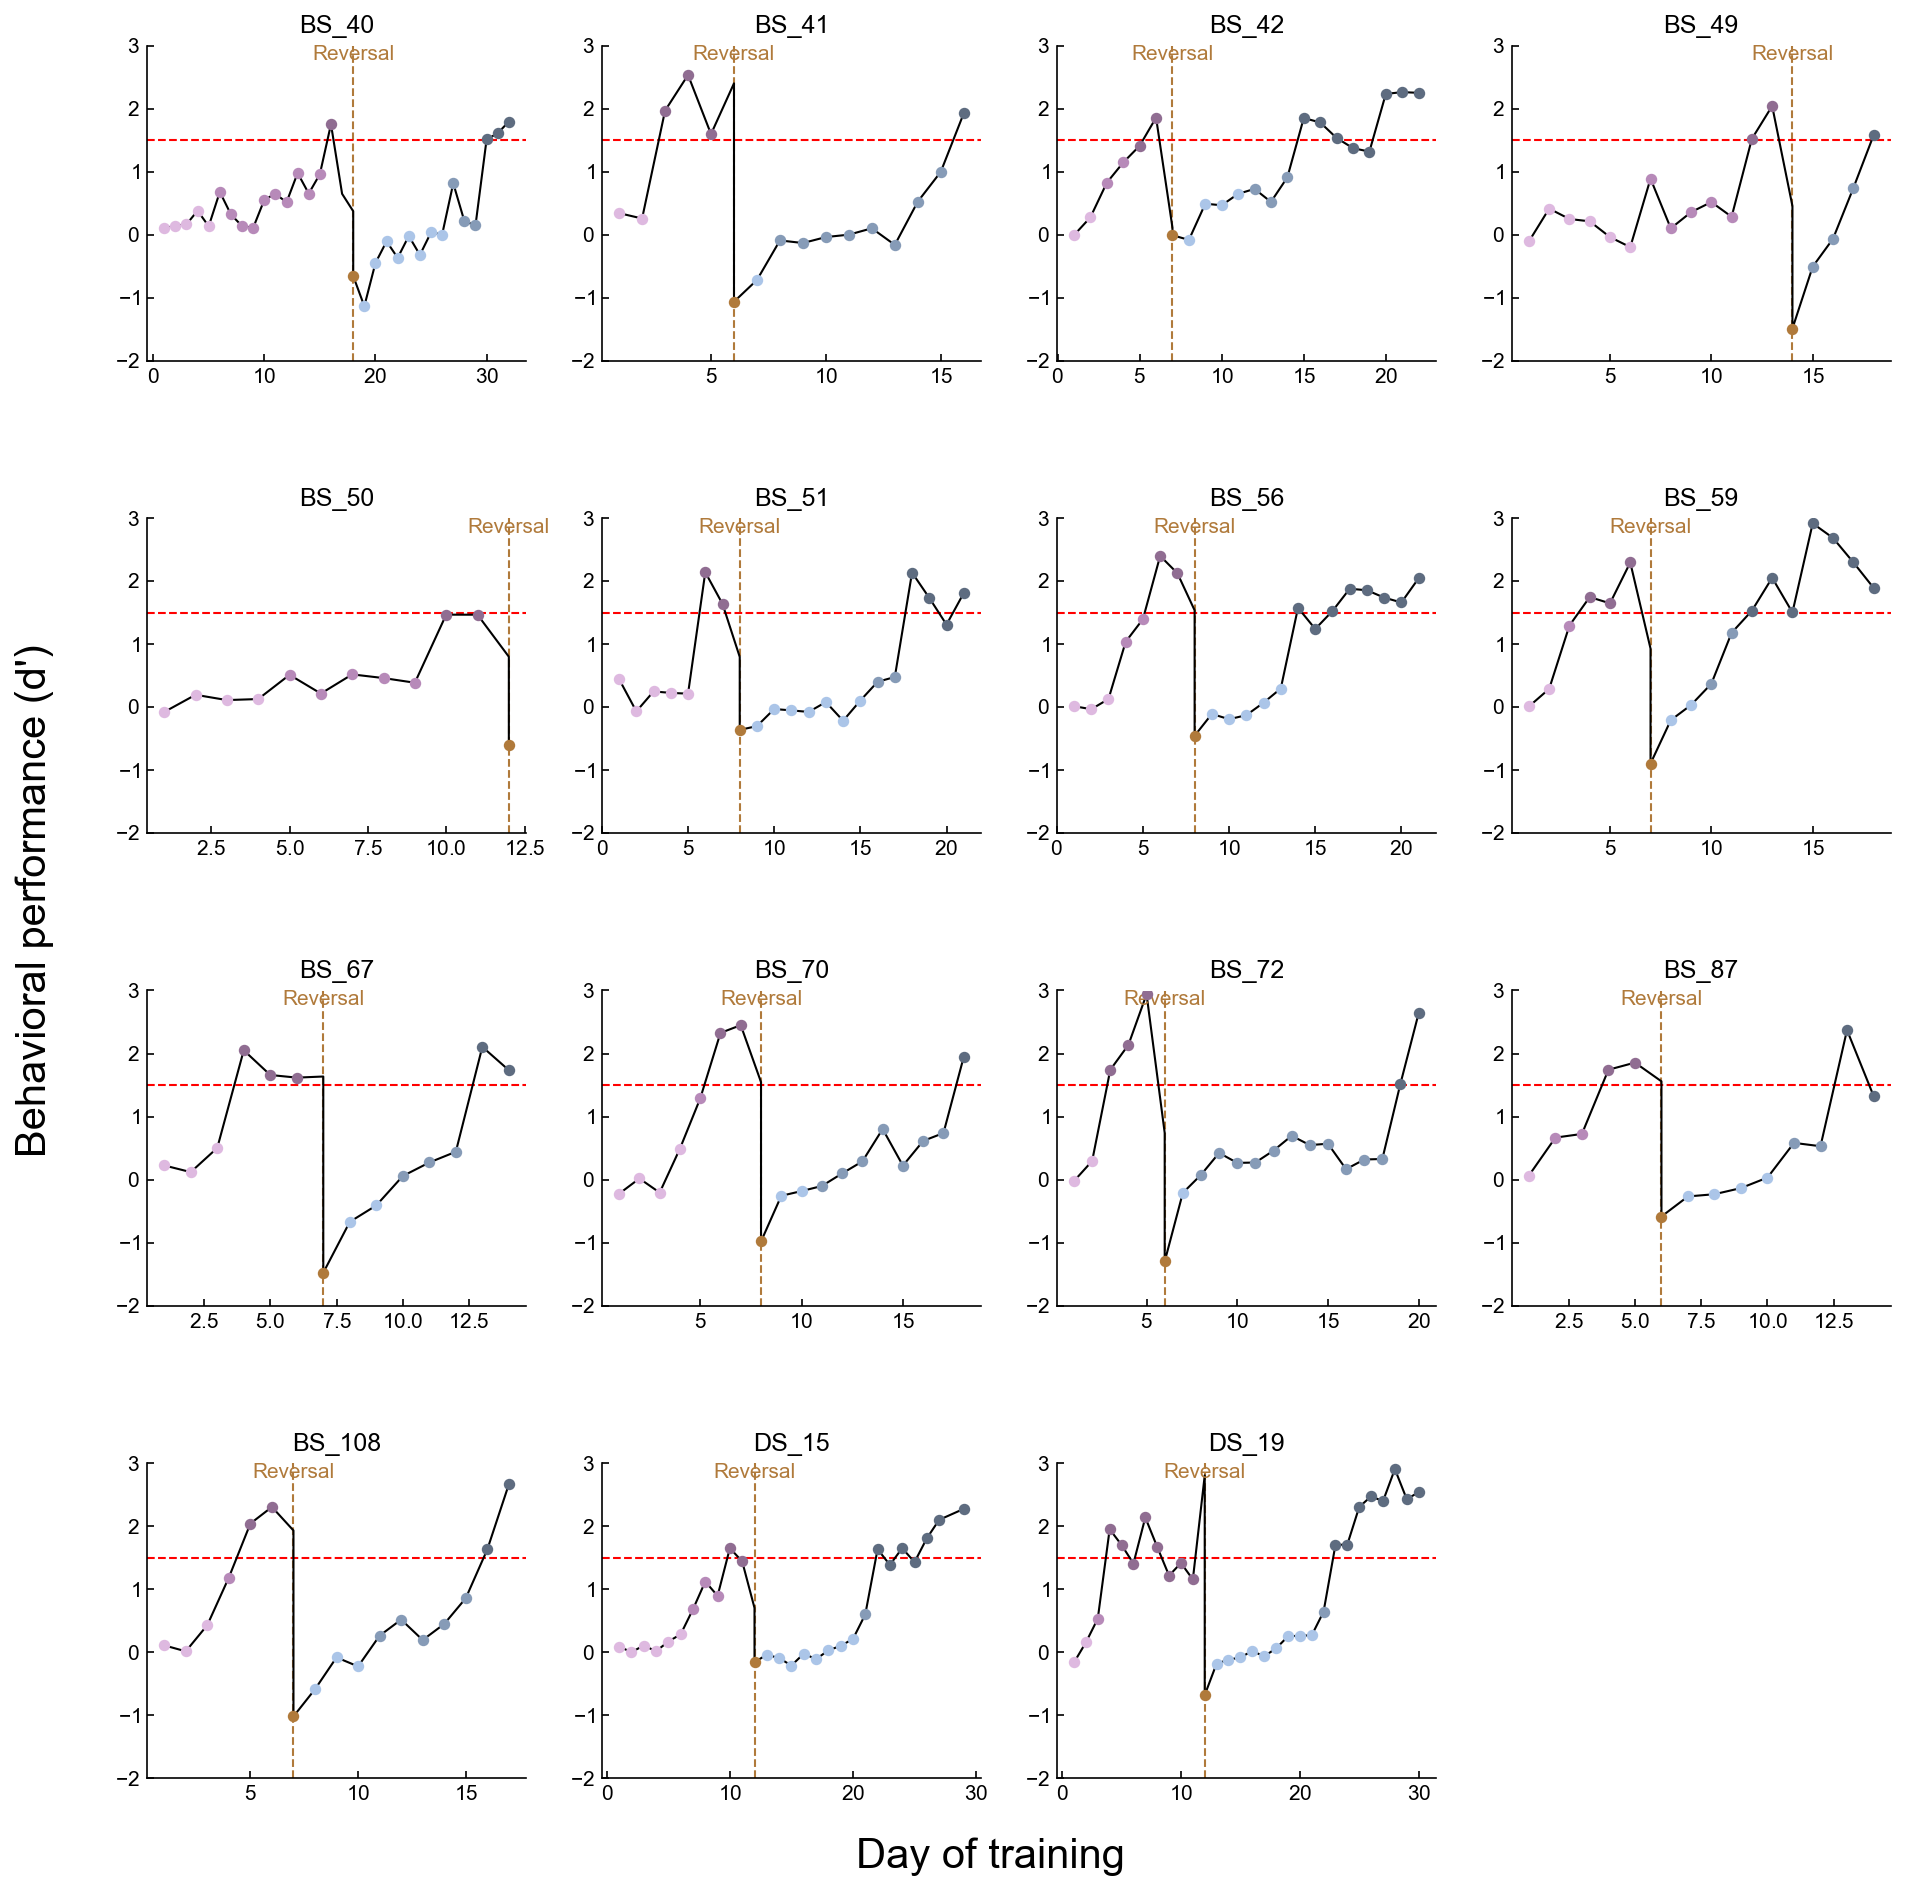

In [3]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

## Get dual data

In [4]:
EnumACSession = []
EnumACClust = []
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(act_directory)

numAC = 0
numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal not in animals:
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass

        
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))

100%|██████████| 554/554 [00:09<00:00, 58.56it/s]

AC       : 1831
M2       : 1624


In [5]:
EILM2phases = np.full_like(EnumM2Session,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumM2Session)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILM2phases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILM2phases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILM2phases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILM2phases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILM2phases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILM2phases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILM2phases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1624/1624 [00:31<00:00, 52.21it/s] 

errors for: []


In [6]:
EILACphases = np.full_like(EnumACSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumACSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILACphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILACphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILACphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILACphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILACphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILACphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILACphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1831/1831 [00:34<00:00, 52.88it/s] 

errors for: []


In [7]:
np.unique(EnumACSession)

array(['BS_108_1_AC.pickle', 'BS_108_2_AC.pickle', 'BS_108_3_AC.pickle',
       'BS_108_4_AC.pickle', 'BS_108_6_AC.pickle', 'BS_40_10_AC.pickle',
       'BS_40_12_AC.pickle', 'BS_40_14_AC.pickle', 'BS_40_15_AC.pickle',
       'BS_40_16_AC.pickle', 'BS_40_18_AC.pickle', 'BS_40_19_AC.pickle',
       'BS_40_21_AC.pickle', 'BS_40_22_AC.pickle', 'BS_40_2_AC.pickle',
       'BS_40_3_AC.pickle', 'BS_40_4_AC.pickle', 'BS_40_5_AC.pickle',
       'BS_40_6_AC.pickle', 'BS_40_7_AC.pickle', 'BS_40_8_AC.pickle',
       'BS_41_11_AC.pickle', 'BS_41_1_AC.pickle', 'BS_41_2_AC.pickle',
       'BS_41_4_AC.pickle', 'BS_41_5_AC.pickle', 'BS_41_6_AC.pickle',
       'BS_41_7_AC.pickle', 'BS_41_8_AC.pickle', 'BS_41_9_AC.pickle',
       'BS_42_10_AC.pickle', 'BS_42_11_AC.pickle', 'BS_42_1_AC.pickle',
       'BS_42_2_AC.pickle', 'BS_42_3_AC.pickle', 'BS_42_4_AC.pickle',
       'BS_42_5_AC.pickle', 'BS_42_6_AC.pickle', 'BS_42_7_AC.pickle',
       'BS_42_8_AC.pickle', 'BS_42_9_AC.pickle', 'BS_49_10_AC.pickle',
  

In [8]:
np.unique(EnumM2Session)

array(['BS_108_1_M2.pickle', 'BS_108_2_M2.pickle', 'BS_108_3_M2.pickle',
       'BS_108_4_M2.pickle', 'BS_108_5_M2.pickle', 'BS_108_6_M2.pickle',
       'BS_108_7_M2.pickle', 'BS_40_10_M2.pickle', 'BS_40_11_M2.pickle',
       'BS_40_13_M2.pickle', 'BS_40_14_M2.pickle', 'BS_40_15_M2.pickle',
       'BS_40_16_M2.pickle', 'BS_40_2_M2.pickle', 'BS_40_3_M2.pickle',
       'BS_40_5_M2.pickle', 'BS_40_6_M2.pickle', 'BS_40_7_M2.pickle',
       'BS_41_11_M2.pickle', 'BS_41_12_M2.pickle', 'BS_41_1_M2.pickle',
       'BS_41_2_M2.pickle', 'BS_41_4_M2.pickle', 'BS_41_5_M2.pickle',
       'BS_41_6_M2.pickle', 'BS_41_7_M2.pickle', 'BS_41_9_M2.pickle',
       'BS_42_10_M2.pickle', 'BS_42_11_M2.pickle', 'BS_42_1_M2.pickle',
       'BS_42_2_M2.pickle', 'BS_42_3_M2.pickle', 'BS_42_4_M2.pickle',
       'BS_42_5_M2.pickle', 'BS_42_6_M2.pickle', 'BS_42_7_M2.pickle',
       'BS_42_8_M2.pickle', 'BS_42_9_M2.pickle', 'BS_49_13_M2.pickle',
       'BS_49_14_M2.pickle', 'BS_49_15_M2.pickle', 'BS_49_1_M2.pickle',


In [10]:
act_directory

'D:\\Analysis_Cache_M2_300'

## FR calculation - AC

In [20]:
EnumSession = EnumACSession
EnumClust = EnumACClust
EILphases = EILACphases

FRmod_preearly_AC = []
FRmod_prelate_AC = []
FRmod_preexpert_AC = []
FRmod_postearly_AC = []
FRmod_postlate_AC = []
FRmod_postexpert_AC = []

ChoiceMod_preearly_AC = []
ChoiceMod_prelate_AC = []
ChoiceMod_preexpert_AC = []
ChoiceMod_postearly_AC = []
ChoiceMod_postlate_AC = []
ChoiceMod_postexpert_AC = []
ChoiceMod_switch_AC = []

preearly_animals_AC = []
prelate_animals_AC = []
preexpert_animals_AC = []
postearly_animals_AC = []
postlate_animals_AC = []
postexpert_animals_AC = []

cellstouseFR = 'all cells'
analysis_condition = 'all_trials'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if sessionfile.meta.animal not in animals:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        FRmod = np.nan
        print(f"{session} - stimulus FRmod: {e}")
    try:
        ChoiceMod = sessionfile.responsiveness[clust][analysis_condition].FRmodulation_choice
    except Exception as e:
        ChoiceMod = np.nan
        print(f"{session} - choice FRmod: {e}")
        
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly_AC.append(FRmod)
        ChoiceMod_preearly_AC.append(ChoiceMod)
        preearly_animals_AC.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate_AC.append(FRmod)
        ChoiceMod_prelate_AC.append(ChoiceMod)
        prelate_animals_AC.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert_AC.append(FRmod)
        ChoiceMod_preexpert_AC.append(ChoiceMod)
        preexpert_animals_AC.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly_AC.append(FRmod)
        ChoiceMod_postearly_AC.append(ChoiceMod)
        postearly_animals_AC.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate_AC.append(FRmod)
        ChoiceMod_postlate_AC.append(ChoiceMod)
        postlate_animals_AC.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert_AC.append(FRmod)
        ChoiceMod_postexpert_AC.append(ChoiceMod)
        postexpert_animals_AC.append(sessionfile.meta.animal)

FRmod_preearly_AC = np.array(FRmod_preearly_AC)
FRmod_prelate_AC = np.array(FRmod_prelate_AC)
FRmod_preexpert_AC = np.array(FRmod_preexpert_AC)
FRmod_postearly_AC = np.array(FRmod_postearly_AC)
FRmod_postlate_AC = np.array(FRmod_postlate_AC)
FRmod_postexpert_AC = np.array(FRmod_postexpert_AC)


1831it [00:36, 50.63it/s] 


In [21]:
preearly_animals_AC = np.unique(preearly_animals_AC)
prelate_animals_AC = np.unique(prelate_animals_AC)
preexpert_animals_AC = np.unique(preexpert_animals_AC)
postearly_animals_AC = np.unique(postearly_animals_AC)
postlate_animals_AC = np.unique(postlate_animals_AC)
postexpert_animals_AC = np.unique(postexpert_animals_AC)

In [22]:
print(preearly_animals_AC)
print(prelate_animals_AC)
print(preexpert_animals_AC)
print(postearly_animals_AC)
print(postlate_animals_AC)
print(postexpert_animals_AC)

['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_40' 'BS_49' 'BS_72' 'BS_87' 'DS_15' 'DS_19']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_42' 'BS_49' 'BS_51' 'BS_56' 'BS_67' 'BS_70' 'BS_87' 'DS_15'
 'DS_19']


In [23]:
print(len(FRmod_preearly_AC))
print(len(FRmod_prelate_AC))
print(len(FRmod_preexpert_AC))
print(len(FRmod_postearly_AC))
print(len(FRmod_postlate_AC))
print(len(FRmod_postexpert_AC))

148
188
117
306
342
264


C:\Users\insan\AppData\Local\Temp\ipykernel_18748\2877595122.py:36: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


3.5533237685317998
2.54335260115607
3.34913112164297
3.3727151344284865
2.172278522392938
2.4736048265460027


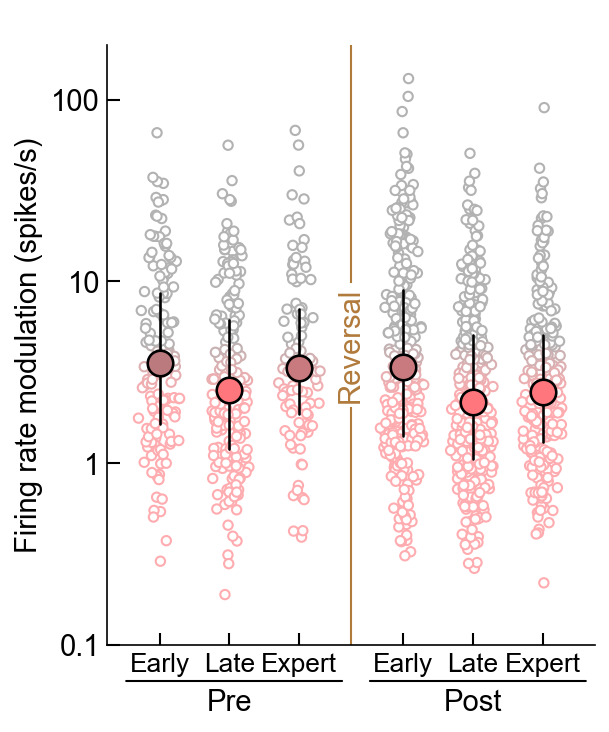

In [24]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
    
FRmod_baseline_median = 3.5
data = [FRmod_preearly_AC,FRmod_prelate_AC,FRmod_preexpert_AC,FRmod_postearly_AC,FRmod_postlate_AC,FRmod_postexpert_AC]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)

    print(median)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\FRmod\\FRmod overlearning AC all cells.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [26]:
FRData_AC = SimpleNamespace()
FRData_AC.preearly = FRmod_preearly_AC
FRData_AC.prelate = FRmod_prelate_AC
FRData_AC.preexpert = FRmod_preexpert_AC
FRData_AC.postearly = FRmod_postearly_AC
FRData_AC.postlate = FRmod_postlate_AC
FRData_AC.postexpert = FRmod_postexpert_AC

In [27]:
ilep.nonparametricIndependentStatsCompareToPrevious(FRData_AC)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source             SS      DF          MS          F     p-unc  \
0            phase    1071.658339     3.0  357.219446   4.493824  0.003782   
1          context     811.480603     1.0  811.480603  10.208434  0.001422   
2  phase * context    2242.529986     3.0  747.509995   9.403683  0.000004   
3         Residual  146740.738761  1846.0   79.491191        NaN       NaN   

        np2  
0  0.007250  
1  0.005500  
2  0.015052  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.165429  0.165429 -0.060037
8     post-late  baseline  experimental  0.000014  0.000055  0.365706
9    pre-expert  baseline  experimental  0.032060  0.042747 -0.226928
10     pre-late  baseline  experimental  0.006777  0.013554  0.231793
key preearly has 148 non-nan elements
key prelate has 187 non-nan elements
key preexpert has 97 non-nan elements
key postearly has 306 non-nan elements
key postlate has 342 non-nan element

In [28]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(FRData_AC)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source             SS      DF           MS          F  \
0            phase      97.175213     3.0    32.391738   0.292141   
1          context    3633.131456     1.0  3633.131456  32.767156   
2  phase * context     830.102721     3.0   276.700907   2.495561   
3         Residual  196363.572664  1771.0   110.877229        NaN   

          p-unc       np2  
0  8.311064e-01  0.000495  
1  1.217613e-08  0.018166  
2  5.825597e-02  0.004210  
3           NaN       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.004666  0.009036  0.294704
8     post-late  baseline  experimental  0.000014  0.000055  0.365706
9    pre-expert  baseline  experimental  0.837156  0.837156 -0.006818
10     pre-late  baseline  experimental  0.006777  0.009036  0.231793
key preearly has 148 non-nan elements
key prelate has 187 non-nan elements
key preexpert has 97 non-nan elements
key postearly has 306 non-nan elements
key postlat

## FR calculation - M2

In [11]:
EnumSession = EnumM2Session
EnumClust = EnumM2Clust
EILphases = EILM2phases

FRmod_preearly_M2 = []
FRmod_prelate_M2 = []
FRmod_preexpert_M2 = []
FRmod_postearly_M2 = []
FRmod_postlate_M2 = []
FRmod_postexpert_M2 = []

ChoiceMod_preearly_M2 = []
ChoiceMod_prelate_M2 = []
ChoiceMod_preexpert_M2 = []
ChoiceMod_postearly_M2 = []
ChoiceMod_postlate_M2 = []
ChoiceMod_postexpert_M2 = []
ChoiceMod_switch_M2 = []

preearly_animals_M2 = []
prelate_animals_M2 = []
preexpert_animals_M2 = []
postearly_animals_M2 = []
postlate_animals_M2 = []
postexpert_animals_M2 = []

cellstouseFR = 'all cells'
analysis_condition = 'all_trials'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if sessionfile.meta.animal not in BS_animal_M2:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        FRmod = np.nan
        print(f"{session} - stimulus FRmod: {e}")
    try:
        ChoiceMod = sessionfile.responsiveness[clust][analysis_condition].FRmodulation_choice
    except Exception as e:
        ChoiceMod = np.nan
        print(f"{session} - choice FRmod: {e}")
        
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly_M2.append(FRmod)
        ChoiceMod_preearly_M2.append(ChoiceMod)
        preearly_animals_M2.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate_M2.append(FRmod)
        ChoiceMod_prelate_M2.append(ChoiceMod)
        prelate_animals_M2.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert_M2.append(FRmod)
        ChoiceMod_preexpert_M2.append(ChoiceMod)
        preexpert_animals_M2.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly_M2.append(FRmod)
        ChoiceMod_postearly_M2.append(ChoiceMod)
        postearly_animals_M2.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate_M2.append(FRmod)
        ChoiceMod_postlate_M2.append(ChoiceMod)
        postlate_animals_M2.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert_M2.append(FRmod)
        ChoiceMod_postexpert_M2.append(ChoiceMod)
        postexpert_animals_M2.append(sessionfile.meta.animal)

FRmod_preearly_M2 = np.array(FRmod_preearly_M2)
FRmod_prelate_M2 = np.array(FRmod_prelate_M2)
FRmod_preexpert_M2 = np.array(FRmod_preexpert_M2)
FRmod_postearly_M2 = np.array(FRmod_postearly_M2)
FRmod_postlate_M2 = np.array(FRmod_postlate_M2)
FRmod_postexpert_M2 = np.array(FRmod_postexpert_M2)

ChoiceMod_preearly_M2 = np.array(ChoiceMod_preearly_M2)
ChoiceMod_prelate_M2 = np.array(ChoiceMod_prelate_M2)
ChoiceMod_preexpert_M2 = np.array(ChoiceMod_preexpert_M2)
ChoiceMod_postearly_M2 = np.array(ChoiceMod_postearly_M2)
ChoiceMod_postlate_M2 = np.array(ChoiceMod_postlate_M2)
ChoiceMod_postexpert_M2 = np.array(ChoiceMod_postexpert_M2)

1624it [00:31, 51.74it/s] 


In [12]:
preearly_animals_M2 = np.unique(preearly_animals_M2)
prelate_animals_M2 = np.unique(prelate_animals_M2)
preexpert_animals_M2 = np.unique(preexpert_animals_M2)
postearly_animals_M2 = np.unique(postearly_animals_M2)
postlate_animals_M2 = np.unique(postlate_animals_M2)
postexpert_animals_M2 = np.unique(postexpert_animals_M2)

In [13]:
print(preearly_animals_M2)
print(prelate_animals_M2)
print(preexpert_animals_M2)
print(postearly_animals_M2)
print(postlate_animals_M2)
print(postexpert_animals_M2)

['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_50' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_42' 'BS_51' 'BS_56' 'BS_59' 'BS_67']


In [14]:
print(len(FRmod_preearly_M2))
print(len(FRmod_prelate_M2))
print(len(FRmod_preexpert_M2))
print(len(FRmod_postearly_M2))
print(len(FRmod_postlate_M2))
print(len(FRmod_postexpert_M2))

159
240
199
306
247
192


C:\Users\insan\AppData\Local\Temp\ipykernel_31384\2428224390.py:36: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


2.6326963906581744
1.7656012176560139
3.1578947368421075
2.2879354540488297
2.3308270676691745
3.7283792440743113


meta NOT subset; don't know how to subset; dropped


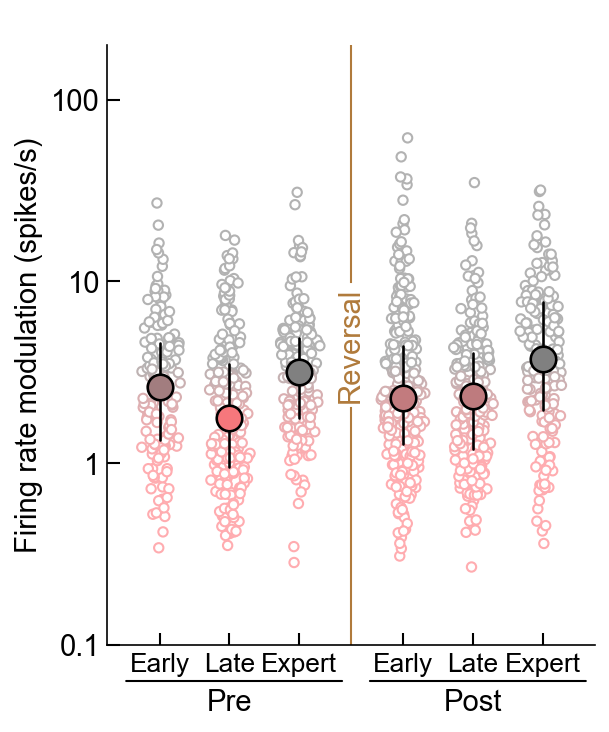

In [20]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 2.3
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
    
FRmod_baseline_median = 2.3
data = [FRmod_preearly_M2,FRmod_prelate_M2,FRmod_preexpert_M2,FRmod_postearly_M2,FRmod_postlate_M2,FRmod_postexpert_M2]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)

    print(median)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\FRmod\\FRmod overlearning M2 all cells_300.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [16]:
FRData_M2 = SimpleNamespace()
FRData_M2.preearly = FRmod_preearly_M2
FRData_M2.prelate = FRmod_prelate_M2
FRData_M2.preexpert = FRmod_preexpert_M2
FRData_M2.postearly = FRmod_postearly_M2
FRData_M2.postlate = FRmod_postlate_M2
FRData_M2.postexpert = FRmod_postexpert_M2

In [17]:
ilep.nonparametricIndependentStatsCompareToPrevious(FRData_M2)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source            SS      DF          MS          F         p-unc  \
0            phase    254.224105     3.0   84.741368   4.303808  4.929280e-03   
1          context     53.564616     1.0   53.564616   2.720417  9.924741e-02   
2  phase * context    836.729132     3.0  278.909711  14.165147  3.990439e-09   
3         Residual  35284.222798  1792.0   19.689856        NaN           NaN   

        np2  
0  0.007153  
1  0.001516  
2  0.023165  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.034380e-07  2.068760e-07 -0.499898
8     post-late  baseline  experimental  4.218176e-01  4.218176e-01  0.177763
9    pre-expert  baseline  experimental  6.370628e-09  2.548251e-08 -0.341704
10     pre-late  baseline  experimental  4.640861e-04  6.187814e-04  0.236764
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 3

In [23]:
6.187814e-04

0.0006187814

In [18]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(FRData_M2)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source            SS      DF          MS         F     p-unc  \
0            phase    479.659539     3.0  159.886513  6.324125  0.000290   
1          context      1.747034     1.0    1.747034  0.069102  0.792680   
2  phase * context    400.161680     3.0  133.387227  5.275977  0.001269   
3         Residual  44774.416534  1771.0   25.281997       NaN       NaN   

        np2  
0  0.010599  
1  0.000039  
2  0.008858  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000007  0.000027 -0.212335
8     post-late  baseline  experimental  0.421818  0.421818  0.177763
9    pre-expert  baseline  experimental  0.061238  0.081651 -0.103047
10     pre-late  baseline  experimental  0.000464  0.000928  0.236764
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 306 non-nan elements
key postlate has 247 non-nan elements
key pos

## compare FRmod between AC and M2

In [38]:
FRmod_baseline_median_AC = 3.5
FRmod_baseline_median_M2 = 2.3

In [98]:
ilep.nonparametricIndependentStatsCompareToOther(FRData_AC,FRData_M2)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source             SS      DF           MS          F  \
0            phase    2442.007595     5.0   488.401519   8.463326   
1          context    4308.968576     1.0  4308.968576  74.668496   
2  phase * context    1736.283589     5.0   347.256718   6.017481   
3         Residual  151598.881913  2627.0    57.707987        NaN   

          p-unc       np2  
0  5.881207e-08  0.015853  
1  9.503498e-18  0.027638  
2  1.519998e-05  0.011323  
3           NaN       NaN  

          phase  A  B         p-unc        p-corr    hedges
16   post-early  A  B  8.581979e-08  2.574594e-07  0.421773
17  post-expert  A  B  2.366076e-02  2.415222e-02 -0.039280
18    post-late  A  B  2.415222e-02  2.415222e-02  0.290179
19    pre-early  A  B  9.289795e-05  1.857959e-04  0.508464
20   pre-expert  A  B  9.355375e-03  1.403306e-02  0.490222
21     pre-late  A  B  5.728048e-08  2.574594e-07  0.512510
key preearly has 148 and 159 non-nan elements
key prelate has 187 and 239 non-nan elements
ke

C:\Users\insan\AppData\Local\Temp\ipykernel_18748\3484245441.py:39: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.2,minjitter=0)
C:\Users\insan\AppData\Local\Temp\ipykernel_18748\3484245441.py:77: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.2,minjitter=0)
meta NOT subset; don't know how to subset; dropped


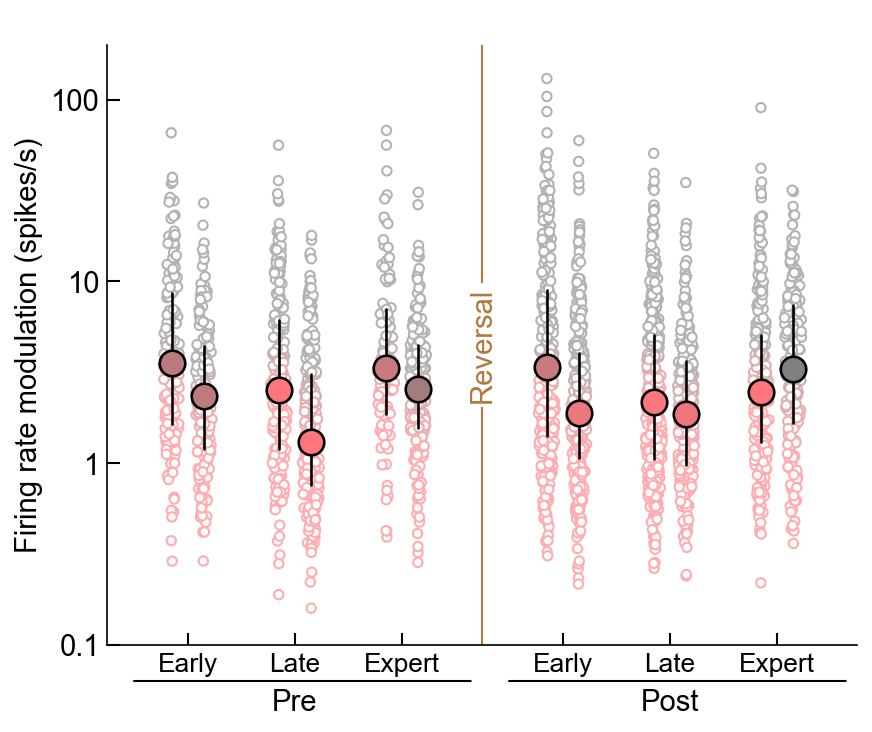

In [73]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(5, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0.25
size = 20
summary_size=150
summary_width=1.25#0.75
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
################################################################################################################
offset_distance = -0.15
size = 20
summary_size=150
summary_width=1.25#0.75
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
mn = FRmod_baseline_median_AC
FRmod_baseline_median = FRmod_baseline_median_AC
data = [FRmod_preearly_AC,FRmod_prelate_AC,FRmod_preexpert_AC,FRmod_postearly_AC,FRmod_postlate_AC,FRmod_postexpert_AC]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.2,minjitter=0)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.2,minjitter=0)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X+offset_distance, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)

    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

#########################  
offset_distance = 0.15

###
mn = FRmod_baseline_median_M2
FRmod_baseline_median = FRmod_baseline_median_M2
data = [FRmod_preearly_M2,FRmod_prelate_M2,FRmod_preexpert_M2,FRmod_postearly_M2,FRmod_postlate_M2,FRmod_postexpert_M2]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.2,minjitter=0)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.2,minjitter=0)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X+offset_distance, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)

    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
    
    
    
    

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\FRmod\\FRmod overlearning AC and M2 all cells.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [100]:
100-49.7

50.3

In [101]:
100-66.1

33.900000000000006

In [102]:
100-45.4

54.6

In [103]:
100-56.9

43.1

In [104]:
100-57.1

42.9

In [105]:
100-37.2

62.8

In [74]:
np.var(FRmod_preearly_AC)

81.06983057983443

In [75]:
np.min(FRmod_preearly_AC)

0.28906955736224027

In [88]:
np.max(FRmod_preearly_AC)

65.79047619047616

In [90]:
np.mean(FRmod_preearly_AC)

7.041143614699935

In [91]:
np.median(FRmod_preearly_AC)

3.5533237685317998

{'whiskers': [<matplotlib.lines.Line2D at 0x2244ed177f0>,
 'caps': [<matplotlib.lines.Line2D at 0x2244ed17d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x2244ed17640>,
 'medians': [<matplotlib.lines.Line2D at 0x2244ed0c370>,
 'fliers': [<matplotlib.lines.Line2D at 0x2244ed0c640>,
 'means': []}

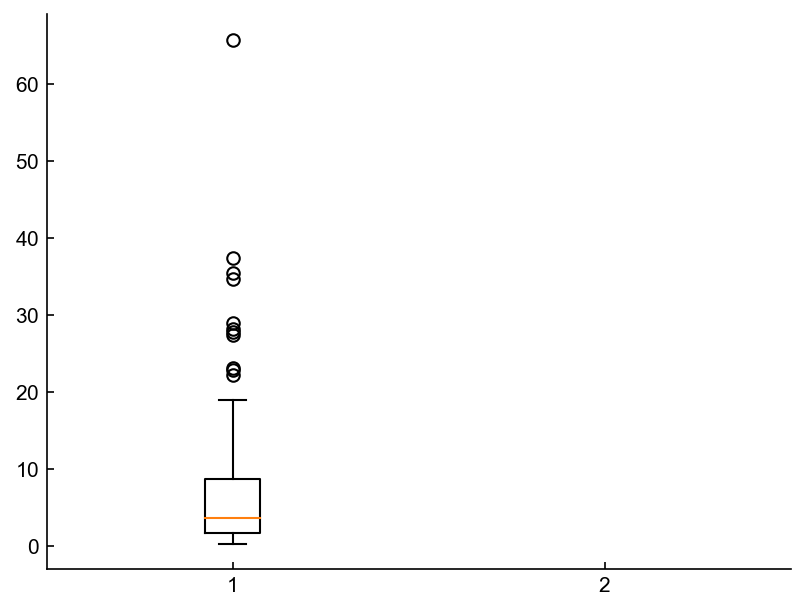

In [97]:
plt.boxplot([FRmod_preearly_AC,FRmod_prelate_AC])

In [77]:
varFRmod_preearly_AC = np.var(FRmod_preearly_AC)
varFRmod_prelate_AC = np.var(FRmod_prelate_AC)
varFRmod_preexpert_AC = np.var(FRmod_preexpert_AC) 
varFRmod_postearly_AC = np.var(FRmod_postearly_AC)
varFRmod_postlate_AC = np.var(FRmod_postlate_AC)
varFRmod_postexpert_AC = np.var(FRmod_postexpert_AC)

In [78]:
varFRmod_preearly_M2 = np.var(FRmod_preearly_M2)
varFRmod_prelate_M2 = np.var(FRmod_prelate_M2)
varFRmod_preexpert_M2 = np.var(FRmod_preexpert_M2) 
varFRmod_postearly_M2 = np.var(FRmod_postearly_M2)
varFRmod_postlate_M2 = np.var(FRmod_postlate_M2)
varFRmod_postexpert_M2 = np.var(FRmod_postexpert_M2)

In [84]:
np.var(FRmod_postexpert_AC)

nan

In [86]:
varFRmod_preearly_AC = np.nanstd(FRmod_preearly_AC)
varFRmod_prelate_AC = np.nanstd(FRmod_prelate_AC)
varFRmod_preexpert_AC = np.nanstd(FRmod_preexpert_AC) 
varFRmod_postearly_AC = np.nanstd(FRmod_postearly_AC)
varFRmod_postlate_AC = np.nanstd(FRmod_postlate_AC)
varFRmod_postexpert_AC = np.nanstd(FRmod_postexpert_AC)

In [87]:
print(varFRmod_preearly_AC)
print(varFRmod_prelate_AC)
print(varFRmod_preexpert_AC) 
print(varFRmod_postearly_AC) 
print(varFRmod_postlate_AC) 
print(varFRmod_postexpert_AC) 

9.003878640887738
7.02609999125708
10.588697986036523
14.099472409782024
6.392464327977511
8.236749073923923
